In [6]:
import pandas as pd
import numpy as np

In [2]:
import os
os.chdir("..")
import helpers

C:\Users\lucah\OneDrive - Durham University\cs_project\helpers\ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
explainer_name = "GradCAM"
h5_output_name = "evaluation_output.h5"
dataset_name = "EuroSATRGB"
model_name = "ConvNeXtSmall"

In [30]:
h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / h5_output_name
if not h5_output_path.parent.exists():
    raise FileNotFoundError(f"Path {h5_output_path.parent} does not exist.")

store = pd.HDFStore(str(h5_output_path))
df_name = f"{dataset_name}_{model_name}"
if df_name not in store:
    raise KeyError(f"Dataframe {df_name} not found in HDF5 file.")
df = store[df_name]

<Axes: >

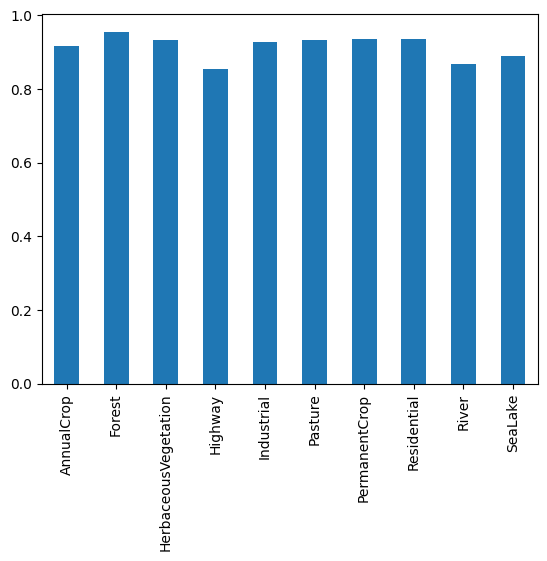

In [38]:
df["compactness : threshold_score"].plot(kind="bar", rot=90)

<Axes: >

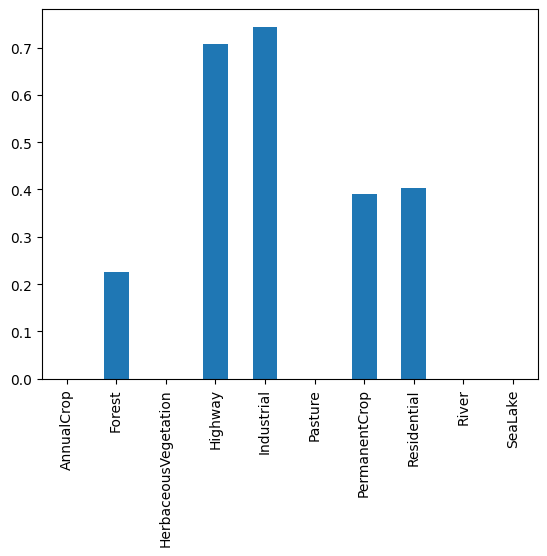

In [39]:
df["continuity : perturbation_similarity : top_k_intersection"].plot(kind="bar", rot=90)

<Axes: >

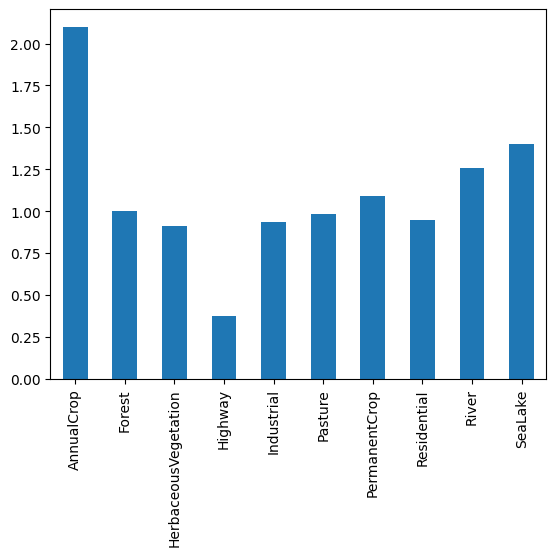

In [41]:
df["correctness : incremental_deletion_auc_ratio"].plot(kind="bar", rot=90)

In [42]:
store.close()

In [43]:
df

,correctness : randomised_model_similarity : l2_distance,correctness : randomised_model_similarity : spearman_rank,correctness : randomised_model_similarity : top_k_intersection,correctness : randomised_model_similarity : structural_similarity,correctness : incremental_deletion_auc_ratio,output_completeness : deletion_check_conf_drop,output_completeness : preservation_check_conf_drop,continuity : perturbation_similarity : l2_distance,continuity : perturbation_similarity : spearman_rank,continuity : perturbation_similarity : top_k_intersection,continuity : perturbation_similarity : structural_similarity,contrastivity : adversarial_attack_similarity : l2_distance,contrastivity : adversarial_attack_similarity : spearman_rank,contrastivity : adversarial_attack_similarity : top_k_intersection,contrastivity : adversarial_attack_similarity : structural_similarity,compactness : threshold_score
AnnualCrop,0.001306,0.092084,0.153597,0.319441,2.100820,-0.069878,0.970212,-inf,-inf,-inf,-inf,0.001182,0.097267,0.166889,0.355190,0.915755
Forest,0.001298,0.207149,0.161756,0.352673,0.998626,0.000004,0.999980,0.000935,0.196669,0.226540,0.352134,0.001010,0.130709,0.156356,0.363573,0.955340
HerbaceousVegetation,0.001315,-0.019387,0.153877,0.285389,0.908401,0.041517,0.619227,-inf,-inf,-inf,-inf,0.001157,0.058053,0.122023,0.346785,0.934003
Highway,0.001532,-0.065481,0.067302,0.267009,0.373225,0.679349,0.032463,0.000564,0.842790,0.707506,0.675731,0.001416,-0.017458,0.127089,0.342100,0.855009
Industrial,0.001215,0.076771,0.116622,0.270107,0.935347,0.072928,0.528402,0.000393,0.851437,0.744353,0.766308,0.001184,0.092702,0.119710,0.328695,0.927988
Pasture,0.001182,-0.001754,0.108002,0.304062,0.984063,0.033215,0.934372,-inf,-inf,-inf,-inf,0.001133,0.071366,0.165556,0.332251,0.933991
PermanentCrop,0.001304,0.033078,0.111620,0.275407,1.088933,0.094258,0.454494,0.000810,0.436751,0.389585,0.490783,0.001149,0.033460,0.113140,0.325863,0.936712
Residential,0.001076,0.196573,0.147411,0.329337,0.948749,0.001439,0.944938,0.000772,0.539409,0.404064,0.526391,0.001161,0.003111,0.096937,0.307662,0.936115
River,0.001444,0.000943,0.076073,0.319632,1.256703,0.132783,0.783298,-inf,-inf,-inf,-inf,0.001238,0.239984,0.170825,0.407126,0.867463
SeaLake,0.001415,0.037917,0.102763,0.349006,1.397969,-0.168446,0.973738,-inf,-inf,-inf,-inf,0.001308,-0.037080,0.101025,0.325291,0.889687


In [45]:
store = pd.HDFStore(str(h5_output_path))
store[df_name] = df
store.close()

In [46]:
store.close()